<a href="https://colab.research.google.com/github/njucs/notebook/blob/master/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **一个简化版本**

1000 0 1.7036445140838623
1000 1 2.1580426692962646
1000 2 1.9425137042999268
1000 3 1.9915900230407715
1000 4 1.7320791482925415
1000 5 1.997324824333191
1000 6 2.2343459129333496
1000 7 2.5416951179504395
1000 8 2.151689291000366
1000 9 2.2996482849121094
1000 10 2.2089641094207764
1000 11 2.4269649982452393
1000 12 2.583895444869995
1000 13 2.097383737564087
1000 14 1.7453162670135498
1000 15 1.5872879028320312
1000 16 2.7771379947662354
1000 17 2.0551986694335938
1000 18 2.1490752696990967
1000 19 2.22421932220459
1000 20 1.8979086875915527
2000 0 2.398923873901367
2000 1 1.900920033454895
2000 2 1.9339745044708252
2000 3 2.286536693572998
2000 4 1.7215046882629395
2000 5 2.0451583862304688
2000 6 2.176642894744873
2000 7 1.9047738313674927
2000 8 2.1407828330993652
2000 9 2.187492847442627
2000 10 1.6026495695114136
2000 11 2.4216160774230957
2000 12 2.1155271530151367
2000 13 1.6203105449676514
2000 14 2.5619282722473145
2000 15 2.1655054092407227
2000 16 2.2000834941864014
2000 

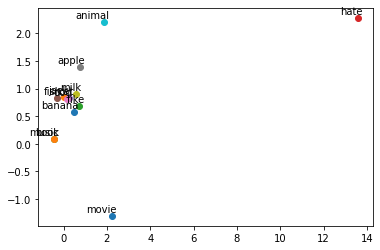

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as Data

dtype = torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 文本预处理
sentences = ["jack like dog", "jack like cat", "jack like animal",
  "dog cat animal", "banana apple cat dog like", "dog fish milk like",
  "dog cat animal like", "jack like apple", "apple like", "jack like banana",
  "apple banana jack movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split() # ['jack', 'like', 'dog', 'jack', 'like', 'cat', 'animal',...]
vocab = list(set(word_sequence)) # build words vocabulary
word2idx = {w: i for i, w in enumerate(vocab)} # {'jack':0, 'like':1,...}

# Word2Vec Parameters
batch_size = 8
embedding_size = 2  # 2 dim vector represent one word
C = 2 # window size
voc_size = len(vocab)

# 1.
skip_grams = []
for idx in range(C, len(word_sequence) - C):
  center = word2idx[word_sequence[idx]] # center word
  context_idx = list(range(idx - C, idx)) + list(range(idx + 1, idx + C + 1)) # context word idx
  context = [word2idx[word_sequence[i]] for i in context_idx]
  for w in context:
    skip_grams.append([center, w])

# 2.
'''
由于 Word2Vec 的输入是 one-hot 表示，所以我们先构建一个对角全 1 的矩阵，
利用 np.eye(rows) 方法，其中的参数 rows 表示全 1 矩阵的行数，
对于这个问题来说，语料库中总共有多少个单词，就有多少行。
然后根据 skip_grams 每行第一列的值，取出相应全 1 矩阵的行。
将这些取出的行，append 到一个 list 中去，最终的这个 list 就是所有的样本 X。
标签不需要 one-hot 表示，只需要类别值，所以只用把 skip_grams 中每行的第二列取出来存起来即可
'''

def make_data(skip_grams):
  input_data = []
  output_data = []
  for i in range(len(skip_grams)):
    input_data.append(np.eye(voc_size)[skip_grams[i][0]])
    output_data.append(skip_grams[i][1])
  return input_data, output_data

# 3.
input_data, output_data = make_data(skip_grams)
input_data, output_data = torch.Tensor(input_data), torch.LongTensor(output_data)
dataset = Data.TensorDataset(input_data, output_data)
loader = Data.DataLoader(dataset, batch_size, True)

# Model
class Word2Vec(nn.Module):
  def __init__(self):
    super(Word2Vec, self).__init__()

    # W and V is not Traspose relationship
    self.W = nn.Parameter(torch.randn(voc_size, embedding_size).type(dtype))
    self.V = nn.Parameter(torch.randn(embedding_size, voc_size).type(dtype))

  def forward(self, X):
    # X : [batch_size, voc_size] one-hot
    # torch.mm only for 2 dim matrix, but torch.matmul can use to any dim
    hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
    output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
    return output_layer

model = Word2Vec().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
for epoch in range(2000):
  for i, (batch_x, batch_y) in enumerate(loader):
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    pred = model(batch_x)
    loss = criterion(pred, batch_y)
    if (epoch + 1) % 1000 == 0:
      print(epoch + 1, i, loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

for i, label in enumerate(vocab):
  W, WT = model.parameters()
  x,y = float(W[i][0]), float(W[i][1])
  plt.scatter(x, y)
  plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()